In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import calendar
import re
import math
import plotly.express as px

#### Next, use the two log files to determine time intervals (hours) when the scheduler was unresponsive. Do this by looking for records that are the "sbatch" command from user 9204 that have return code 1 and an execution time of ~20 seconds (at least more than 15). These are commands where the scheduler timed out in responding.

3. Calculate some descriptive statistics about how often the scheduler was unresponsive, how long these periods of time were, and create a time series plot of when the scheduler was having difficulties.


In [2]:
#reading ce5 data
ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log', 
                  sep = ' - ', 
                  engine = 'python', 
                  names = ['TIME', 'USER', 'RETRY', 'LAPSEDTIME', 'RETURNCODE', 'COMMAND'])

In [3]:
#cleanin ce5 data

ce5['TIME'] = pd.to_datetime(ce5['TIME'])
ce5['USER'] = ce5['USER'].str.extract(r'(\d+)')
ce5['LAPSEDTIME'] = ce5['LAPSEDTIME'].str.replace('time', '').astype('float')
ce5['RETURNCODE'] = ce5['RETURNCODE'].str.extract('(\d+)')
ce5['COMMAND'] = ce5['COMMAND'].str.extract(r"bin/(s\w+)'")
ce5['RETRY'] = ce5['RETRY'].str.slice(start = 6)


In [4]:
#instead of replace and extract in the cell above, we can also use slice
#ce5['RETRY'] = ce5['RETRY'].str.slice(start = 6)
#ce5['LAPSEDTIME'] = ce5['LAPSEDTIME'].str.slice(start = 5)

In [5]:
ce5.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND
0,2020-10-16 08:15:39.278699,0,0,0.073476,0,sacct
1,2020-10-16 08:18:08.313309,0,0,0.183632,0,sacct
2,2020-10-16 08:22:48.128689,0,0,0.075471,0,sacct


In [6]:
ce5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770893 entries, 0 to 4770892
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   TIME        datetime64[ns]
 1   USER        object        
 2   RETRY       object        
 3   LAPSEDTIME  float64       
 4   RETURNCODE  object        
 5   COMMAND     object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 218.4+ MB


In [7]:
#read ce5 into a new df
ce5.to_csv('../data/ce5_clean.csv',
          index= False)

In [8]:
#reading ce6 data
ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log', 
                  sep = ' - ', 
                  engine = 'python', 
                  names = ['TIME', 'USER', 'RETRY', 'LAPSEDTIME', 'RETURNCODE', 'COMMAND'])

In [9]:
#cleaning ce6 data
ce6['TIME'] = pd.to_datetime(ce6['TIME'])
ce6['USER'] = ce6['USER'].str.extract(r'(\d+)')
ce6['LAPSEDTIME'] = ce6['LAPSEDTIME'].str.replace('time', '').astype('float')
ce6['RETURNCODE'] = ce6['RETURNCODE'].str.extract('(\d+)')
ce6['COMMAND'] = ce6['COMMAND'].str.extract(r"bin/(s\w+)'")
ce6['RETRY'] = ce6['RETRY'].str.slice(start = 6)

In [10]:
#ce6.head(3)
ce6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776520 entries, 0 to 4776519
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   TIME        datetime64[ns]
 1   USER        object        
 2   RETRY       object        
 3   LAPSEDTIME  float64       
 4   RETURNCODE  object        
 5   COMMAND     object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 218.7+ MB


In [11]:
#read ce6 into a new df
ce6.to_csv('../data/ce6_clean.csv',
          index=False)

In [12]:
#specifing where the rows are coming from
ce5['server']='ce5'
ce6['server']='ce6'

In [13]:
#concatinating ce5 and ce6
ce5_ce6=(ce5.append(ce6,
                  ignore_index=True
                  )
            .sort_values('TIME',
                        ascending=True
                        )
            .astype({'LAPSEDTIME': 'float64'
                    })
            )
ce5_ce6.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server
0,2020-10-16 08:15:39.278699,0,0,0.073476,0,sacct,ce5
1,2020-10-16 08:18:08.313309,0,0,0.183632,0,sacct,ce5
2,2020-10-16 08:22:48.128689,0,0,0.075471,0,sacct,ce5


In [15]:
#adding unresponsive column
ce5_ce6['UNRESPONSIVE']= (ce5_ce6['LAPSEDTIME']>=15.0) & (ce5_ce6['RETURNCODE']=='1')
ce5_ce6.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server,UNRESPONSIVE
0,2020-10-16 08:15:39.278699,0,0,0.073476,0,sacct,ce5,False
1,2020-10-16 08:18:08.313309,0,0,0.183632,0,sacct,ce5,False
2,2020-10-16 08:22:48.128689,0,0,0.075471,0,sacct,ce5,False


In [16]:
#counts of unresponsive by server
ce5_ce6.groupby(['server', 'UNRESPONSIVE'])['UNRESPONSIVE'].count()

server  UNRESPONSIVE
ce5     False           4335065
        True             435828
ce6     False           4197982
        True             578538
Name: UNRESPONSIVE, dtype: int64

In [17]:
ce5_ce6.head(5)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server,UNRESPONSIVE
0,2020-10-16 08:15:39.278699,0,0,0.073476,0,sacct,ce5,False
1,2020-10-16 08:18:08.313309,0,0,0.183632,0,sacct,ce5,False
2,2020-10-16 08:22:48.128689,0,0,0.075471,0,sacct,ce5,False
3,2020-10-16 08:25:13.257408,0,0,0.094844,0,sacct,ce5,False
4,2020-10-16 08:31:01.460723,0,0,0.074988,0,sacct,ce5,False


In [18]:
#read into a new df
ce5_ce6.to_csv('../data/both_logs.csv',
              index= False)

In [19]:
#limiting the data to sbatch and finding out the timeouts 
time_outs=ce5_ce6[(ce5_ce6['USER']=='9204') &
                 (ce5_ce6['RETURNCODE']=='1') &
                 (ce5_ce6 ['LAPSEDTIME']>15.0) &
                 (ce5_ce6['COMMAND']=='sbatch')]

time_outs.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server,UNRESPONSIVE
4807806,2020-10-18 06:16:25.392946,9204,0,20.037672,1,sbatch,ce6,True
4808498,2020-10-18 06:38:44.172473,9204,0,20.038736,1,sbatch,ce6,True
49958,2020-10-18 06:53:44.272915,9204,0,20.038464,1,sbatch,ce5,True


In [20]:
#time outs per hour 
time_outs=time_outs.sort_values('TIME')
time_outs['time_out_per_hour'] = (time_outs
                                 .rolling ('1h', on= 'TIME')['USER']
                                 .count() 
                                 )
time_outs.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server,UNRESPONSIVE,time_out_per_hour
4807806,2020-10-18 06:16:25.392946,9204,0,20.037672,1,sbatch,ce6,True,1.0
4808498,2020-10-18 06:38:44.172473,9204,0,20.038736,1,sbatch,ce6,True,2.0
49958,2020-10-18 06:53:44.272915,9204,0,20.038464,1,sbatch,ce5,True,3.0


In [21]:
#time outs per week
time_outs=time_outs.sort_values('TIME')
time_outs['time_out_per_week'] = (time_outs
                                 .rolling ('7d', on= 'TIME')['USER']
                                 .count() 
                                 )
time_outs.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server,UNRESPONSIVE,time_out_per_hour,time_out_per_week
4807806,2020-10-18 06:16:25.392946,9204,0,20.037672,1,sbatch,ce6,True,1.0,1.0
4808498,2020-10-18 06:38:44.172473,9204,0,20.038736,1,sbatch,ce6,True,2.0,2.0
49958,2020-10-18 06:53:44.272915,9204,0,20.038464,1,sbatch,ce5,True,3.0,3.0


In [22]:
#reading time outs to a new df
time_outs.to_csv('../data/time_outs.csv',
                index=False)

In [23]:
time_outs.describe()

,LAPSEDTIME,time_out_per_hour,time_out_per_week
count,3296.000000,3296.000000,3296.000000
mean,20.361547,4.503034,149.728459
std,2.352944,4.156643,141.356996
min,19.025584,1.000000,1.000000
25%,20.033297,2.000000,48.000000
50%,20.040104,3.000000,99.000000
75%,20.046859,6.000000,211.000000
max,43.078285,26.000000,564.000000


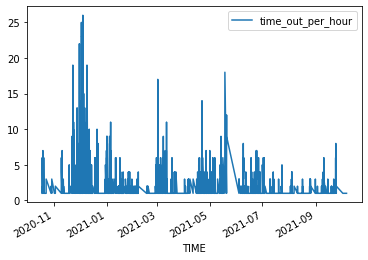

In [24]:
#plotting time out per hour
time_outs.plot(x='TIME',
              y= 'time_out_per_hour');

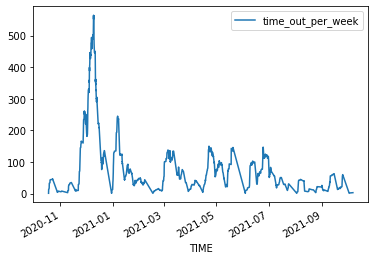

In [25]:
#plotting time out per week
time_outs.plot(x='TIME',
              y= 'time_out_per_week');

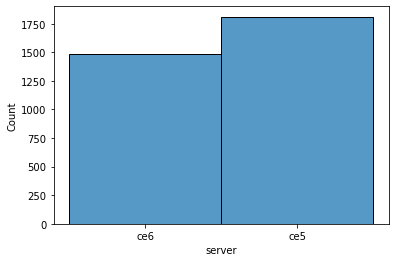

In [26]:
##plotting time out per server
sns.histplot(data = time_outs,
            x = 'server');

In [27]:
#below codes limit the data set to sbatch and user 9204

In [28]:
#limiting the data to sbatch 
sbatch= ce5_ce6[ce5_ce6['COMMAND'].str.contains('sbatch')]

In [29]:
#seperating the user 9204 info
user_9204= sbatch[sbatch['USER']=='9204']

In [30]:
#finding out when user 9204 was unresponsive  
unresponsive= user_9204.loc[(user_9204['RETURNCODE']=='1') & (user_9204['LAPSEDTIME']>15)]
unresponsive.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server,UNRESPONSIVE
4807806,2020-10-18 06:16:25.392946,9204,0,20.037672,1,sbatch,ce6,True
4808498,2020-10-18 06:38:44.172473,9204,0,20.038736,1,sbatch,ce6,True
49958,2020-10-18 06:53:44.272915,9204,0,20.038464,1,sbatch,ce5,True


In [31]:
#proportion of time outs 
unresponsive.shape[0]/user_9204.shape[0]

0.05381488072885202

In [32]:
unresponsive['LAPSEDTIME'].describe()

count    3296.000000
mean       20.361547
std         2.352944
min        19.025584
25%        20.033297
50%        20.040104
75%        20.046859
max        43.078285
Name: LAPSEDTIME, dtype: float64

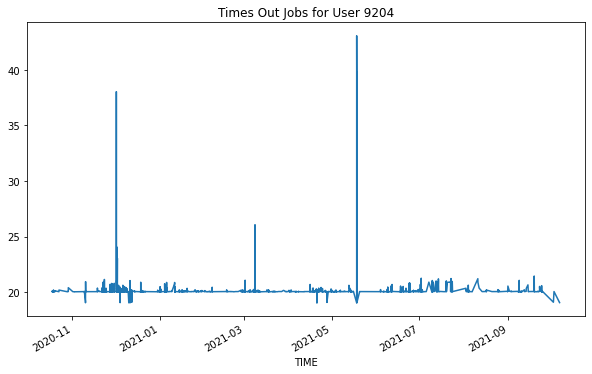

In [33]:
#plot time out jobs for user 9204 
unresponsive[['TIME', 'LAPSEDTIME']].set_index('TIME')['LAPSEDTIME'].plot(figsize=(10,6))
plt.title('Times Out Jobs for User 9204');

In [34]:
#getting data for user 9204 that were sucessful
comp_9204=user_9204.loc[(user_9204['RETURNCODE']=='0') & (user_9204['LAPSEDTIME']<15)]
comp_9204.head(3)

,TIME,USER,RETRY,LAPSEDTIME,RETURNCODE,COMMAND,server,UNRESPONSIVE
136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,sbatch,ce5,False
478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,sbatch,ce5,False
670,2020-10-16 09:04:56.472464,9204,0,0.066345,0,sbatch,ce5,False


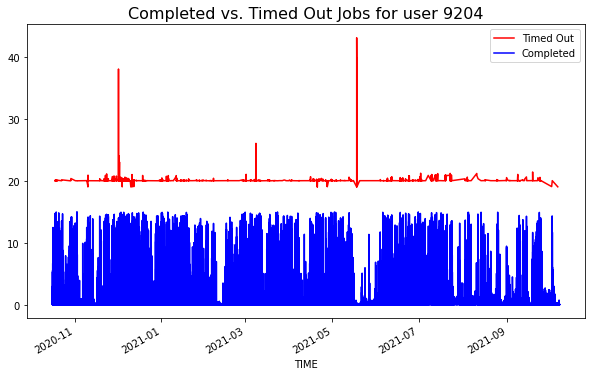

In [35]:
#plotting completed jobs vs. timesd out jobs for user 9204
plt.figure (figsize=(10,6))
unresponsive[['TIME', 'LAPSEDTIME']].set_index('TIME')['LAPSEDTIME'].plot(color= 'red', label='Timed Out')
comp_9204[['TIME', 'LAPSEDTIME']].set_index('TIME')['LAPSEDTIME'].plot(color='blue', label= 'Completed')
plt.title('Completed vs. Timed Out Jobs for user 9204', fontsize= 16)
plt.legend();